In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision

import fastai
from fastai import *
from fastai.vision import *

import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['animation.embed_limit'] = 10e7
matplotlib.rcParams['animation.html'] = 'jshtml'

from IPython.display import HTML

In [2]:
fastai.__version__, torch.__version__, torchvision.__version__

('1.0.58.dev0', '1.2.0', '0.4.0')

# Do a simple y = ax + b fit via gradient descent 

In [3]:
A_true = torch.Tensor([[10], [30]])

In [4]:
x = torch.ones(100, 2)
x[:, 0].uniform_(0, 2);

#### Get "measurements"

In [5]:
y = x@A_true + torch.randn(x.shape[0], 1)

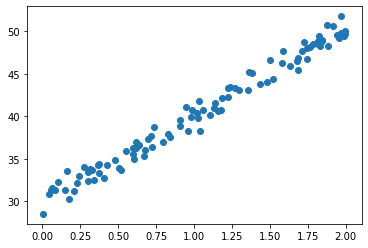

In [6]:
plt.scatter(x[:, 0], y)

#### Do simple gradient descent

In [7]:
A = torch.tensor([[1.], [-1.]], requires_grad=True)
lr = 1e-1

In [8]:
def update():
    y_hat = x@A
    l = ((y-y_hat)**2).mean()
    l.backward()
    with torch.no_grad():
        A.sub_(lr * A.grad)
        A.grad.zero_()
    return l.item()

In [9]:
for i in range(100):
    l = update()
    if i % 10 == 0:
        print(f'Iteration: {i} Loss: {l}')

Iteration: 0 Loss: 1665.282958984375
Iteration: 10 Loss: 28.683584213256836
Iteration: 20 Loss: 15.114239692687988
Iteration: 30 Loss: 8.147924423217773
Iteration: 40 Loss: 4.569193363189697
Iteration: 50 Loss: 2.730738878250122
Iteration: 60 Loss: 1.7862887382507324
Iteration: 70 Loss: 1.301109790802002
Iteration: 80 Loss: 1.051863193511963
Iteration: 90 Loss: 0.9238210916519165


In [10]:
y_hat = x@A

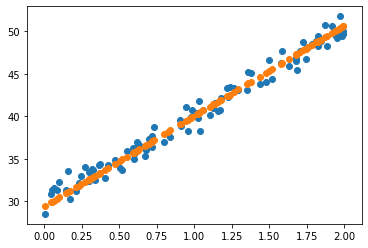

In [11]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], y_hat)

In [12]:
A = torch.tensor([[1.], [-1.]], requires_grad=True)

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@A)
plt.close()

def animate(i):
    update()
    line.set_ydata(x@A)
    return

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

# The above was full on gradient descent; try making a stochastic version

#### I used exact data from fastai spreadsheet so I could cross check my results

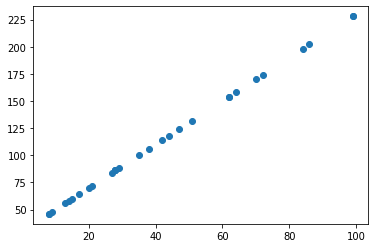

In [13]:
x = torch.tensor([14., 86,28, 51,28,29, 72, 62, 84,15, 42, 62, 47, 35, 9, 38, 44, 99,13,21,28,20, 8, 64, 99, 70,27,17, 8]).unsqueeze(0).t()
y = torch.tensor([58.,202,86,132,86,88,174,154,198,60,114,154,124,100,48,106,118,228,56,72,86,70,46,158,228,170,84,64,46]).unsqueeze(0).t()
plt.scatter(x,y)

#### Get solution

In [14]:
A_true, _ = torch.lstsq(y, torch.cat([x, torch.ones([x.shape[0], 1])], 1))
A_true = A_true[0:2,:] # First n rows contain solution
A_true

tensor([[ 2.0000],
        [30.0000]])

# For fun, make basic pytorch API classes

#### Dataset/Dataloader classes

In [15]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__ (self):
        return self.x.shape[0]

In [16]:
class Dataloader():
    def __init__(self, d):
        self.d = d
        self.idx = 0
    
    def __iter__(self):
        return self

    def __next__ (self):
        if self.idx >= len(self.d):
            self.idx = 0
            raise StopIteration
        x, y = self.d[self.idx]
        self.idx += 1
        return x, y

#### Optimizer; this will house a reference to model parameters and then increment them after loss and gradient are computed

In [17]:
class Optimizer():
    
    def step(self):
        raise NotImplementedError

#### Model; this needs to be callable with dependent variable and also keep/return parameters

In [18]:
class Model():
    
    def __call__(self):
        raise NotImplementedError
        
    def get_params(self):
        raise NotImplementedError

#### Learner; this needs to house dataloader, model, loss function, and optimizer; for now validation set stuff is skipped

In [19]:
class Learner():
    def __init__(self, dataloader, model, loss, optimizer):
        self.dataloader = dataloader
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
    
    def _fit_batch(self, x, y):
        y_hat = self.model(x)
        l = self.loss(y, y_hat)
        l.backward()
        self.optimizer.step()
        return l        
    
    def fit_next_batch(self):
        try:
            x,y = next(self.dataloader)
        except StopIteration:
            x,y = next(self.dataloader)
        l = self._fit_batch(x, y)
        return l.item()
    
    def fit_one_epoch(self):
        for x,y in self.dataloader:
            self._fit_batch(x, y)

#### Create model, loss function, and get dataset/dataloader

In [20]:
class Line(Model):
    def __init__(self):
        self.A = torch.tensor([[1.], [1.]], requires_grad=True)
    
    def __call__(self, x):
        return self.A[0, 0]*x + self.A[1, 0]
    
    def get_params(self):
        return self.A
    
def mse(y, y_hat):
    return ((y-y_hat)**2).mean()

ds = Dataset(x, y)
dl = Dataloader(ds)

#### Simple plotting function

In [21]:
def _learn_one_epoch(learner):
    for _ in range(len(ds)):
        l = learner.fit_next_batch()
        print(f'loss: {l:8.2f} new a: {learner.model.A[0,0].item():4.2f} new b: {learner.model.A[1,0].item():4.2f}')

In [22]:
def _animate_learner(learner):
    fig = plt.figure()
    plt.scatter(x, y, c='orange')
    plot, = plt.plot(x, learner.model(x))
    plt.close()

    def animate(i):
        l = learner.fit_next_batch()
        plot.set_ydata(learner.model(x))
        return

    return HTML(animation.FuncAnimation(fig, animate, np.arange(0, 10*len(ds)-1), interval=20).to_html5_video())

# Regular gradient descent

In [23]:
class GD(Optimizer):
    def __init__(self, p, lr):
        self.p = p
        self.lr = lr
                
    def step(self):
        with torch.no_grad():
            self.p.sub_(self.lr*self.p.grad)
            self.p.grad.zero_()

In [24]:
def _get_gd_learner():
    lr = 1e-4
    model = Line()
    optimizer = GD(model.get_params(), lr)
    learner = Learner(dataloader=dl,
                      model=model, 
                      loss=mse,
                      optimizer=optimizer)
    return learner

In [25]:
_learn_one_epoch(_get_gd_learner())

loss:  1849.00 new a: 1.12 new b: 1.01
loss: 10948.90 new a: 2.92 new b: 1.03
loss:    10.28 new a: 2.94 new b: 1.03
loss:   356.22 new a: 2.75 new b: 1.03
loss:    65.56 new a: 2.79 new b: 1.03
loss:    36.42 new a: 2.83 new b: 1.03
loss:   930.07 new a: 2.39 new b: 1.02
loss:    24.96 new a: 2.45 new b: 1.02
loss:    76.01 new a: 2.30 new b: 1.02
loss:   597.49 new a: 2.38 new b: 1.03
loss:   174.17 new a: 2.49 new b: 1.03
loss:     1.42 new a: 2.47 new b: 1.03
loss:    46.25 new a: 2.54 new b: 1.03
loss:   104.49 new a: 2.61 new b: 1.03
loss:   552.36 new a: 2.65 new b: 1.04
loss:    18.33 new a: 2.68 new b: 1.04
loss:     1.10 new a: 2.67 new b: 1.04
loss:  1417.23 new a: 1.93 new b: 1.03
loss:   894.77 new a: 2.01 new b: 1.04
loss:   832.57 new a: 2.13 new b: 1.04
loss:   646.12 new a: 2.27 new b: 1.05
loss:   555.92 new a: 2.36 new b: 1.05
loss:   678.25 new a: 2.40 new b: 1.06
loss:     9.25 new a: 2.44 new b: 1.06
loss:   224.33 new a: 2.15 new b: 1.06
loss:   347.81 new a: 2.4

In [26]:
_animate_learner(_get_gd_learner())

# Gradient descent with momentum

In [27]:
class MGD(Optimizer):
    def __init__(self, p, lr, mom=0.9):
        self.p = p
        self.lr = lr
        self.mom = mom
                
    def step(self):
        with torch.no_grad():
            if not hasattr(self, 'g_prev'):
                self.g_prev = 0
            g = (1-self.mom)*self.p.grad + self.mom*self.g_prev
            self.p.sub_(self.lr*g)
            self.p.grad.zero_()            
            self.g_prev = g

In [28]:
def _get_mgd_learner():
    lr = 1e-4
    model = Line()
    optimizer = MGD(model.get_params(), lr)
    learner = Learner(dataloader=dl,
                      model=model, 
                      loss=mse,
                      optimizer=optimizer)
    return learner

In [29]:
_learn_one_epoch(_get_mgd_learner())

loss:  1849.00 new a: 1.01 new b: 1.00
loss: 12987.72 new a: 1.22 new b: 1.00
loss:  2587.46 new a: 1.43 new b: 1.01
loss:  3350.26 new a: 1.69 new b: 1.01
loss:  1427.79 new a: 1.93 new b: 1.02
loss:   954.73 new a: 2.18 new b: 1.02
loss:   267.74 new a: 2.42 new b: 1.03
loss:    10.15 new a: 2.64 new b: 1.03
loss:   600.12 new a: 2.79 new b: 1.03
loss:   290.95 new a: 2.94 new b: 1.04
loss:   111.18 new a: 3.06 new b: 1.04
loss:  1368.95 new a: 3.13 new b: 1.04
loss:   580.78 new a: 3.16 new b: 1.04
loss:   139.46 new a: 3.19 new b: 1.04
loss:   333.30 new a: 3.21 new b: 1.05
loss:   294.60 new a: 3.22 new b: 1.05
loss:   617.94 new a: 3.21 new b: 1.05
loss:  8243.06 new a: 3.02 new b: 1.05
loss:   247.28 new a: 2.85 new b: 1.04
loss:   123.78 new a: 2.70 new b: 1.04
loss:    86.50 new a: 2.57 new b: 1.04
loss:   304.87 new a: 2.47 new b: 1.04
loss:   635.97 new a: 2.37 new b: 1.04
loss:    24.74 new a: 2.30 new b: 1.04
loss:     0.27 new a: 2.23 new b: 1.04
loss:   170.10 new a: 2.1

In [30]:
_animate_learner(_get_mgd_learner())

# RMSPROP

In [31]:
class RMSPROP(Optimizer):
    def __init__(self, p, lr, mom=0.9, eps=1e-6):
        self.p = p
        self.lr = lr
        self.mom = mom
        self.eps = eps
                
    def step(self):
        with torch.no_grad():
            if not hasattr(self, 'v_prev'):
                self.v_prev = 0
            v = (1-self.mom)*(self.p.grad**2) + self.mom*self.v_prev
            self.p.sub_(self.lr*(1/(torch.sqrt(v)+self.eps))*self.p.grad)
            self.p.grad.zero_()            
            self.v_prev = v

In [32]:
def _get_rmsprop_learner():
    lr = 0.5
    model = Line()
    optimizer = RMSPROP(model.get_params(), lr)
    learner = Learner(dataloader=dl,
                      model=model, 
                      loss=mse,
                      optimizer=optimizer)
    return learner

In [33]:
_learn_one_epoch(_get_rmsprop_learner())

loss:  1849.00 new a: 2.58 new b: 2.58
loss:   508.91 new a: 1.06 new b: 1.82
loss:  2957.42 new a: 2.05 new b: 3.04
loss:   602.51 new a: 2.80 new b: 3.59
loss:    16.72 new a: 2.87 new b: 3.69
loss:     1.21 new a: 2.89 new b: 3.71
loss:  1431.77 new a: 1.67 new b: 2.88
loss:  2247.34 new a: 2.71 new b: 3.78
loss:  1143.16 new a: 1.83 new b: 3.16
loss:   860.83 new a: 1.98 new b: 3.69
loss:   744.02 new a: 2.36 new b: 4.20
loss:    12.80 new a: 2.44 new b: 4.26
loss:    27.35 new a: 2.53 new b: 4.37
loss:    51.61 new a: 2.62 new b: 4.52
loss:   394.21 new a: 2.70 new b: 4.95
loss:     2.15 new a: 2.67 new b: 4.92
loss:    20.82 new a: 2.58 new b: 4.81
loss:  1055.89 new a: 1.48 new b: 4.08
loss:  1067.64 new a: 1.63 new b: 4.78
loss:  1084.50 new a: 1.89 new b: 5.44
loss:   761.38 new a: 2.19 new b: 6.00
loss:   407.76 new a: 2.35 new b: 6.41
loss:   430.86 new a: 2.43 new b: 6.84
loss:    16.48 new a: 2.31 new b: 6.75
loss:    53.38 new a: 1.97 new b: 6.58
loss:   637.01 new a: 2.7

In [34]:
_animate_learner(_get_rmsprop_learner())

# ADAM (momentum + RMSPROP)

In [35]:
class ADAM(Optimizer):
    def __init__(self, p, lr, moms=(0.95, 0.9), eps=1e-6):
        self.p = p
        self.lr = lr
        self.moms = moms
        self.eps = eps
                
    def step(self):
        with torch.no_grad():
            if not hasattr(self, 'g_prev'): 
                self.g_prev = 0
            if not hasattr(self, 'v_prev'):
                self.v_prev = 0
            g = (1-self.moms[0])*self.p.grad      + self.moms[0]*self.g_prev
            v = (1-self.moms[1])*(self.p.grad**2) + self.moms[1]*self.v_prev
            self.p.sub_(self.lr*(1/(torch.sqrt(v)+self.eps))*g)
            self.p.grad.zero_()           
            self.g_prev = g
            self.v_prev = v

In [36]:
def _get_adam_learner():
    lr = 0.5
    model = Line()
    optimizer = ADAM(model.get_params(), lr)
    learner = Learner(dataloader=dl,
                      model=model, 
                      loss=mse,
                      optimizer=optimizer)
    return learner

In [37]:
_learn_one_epoch(_get_adam_learner())

loss:  1849.00 new a: 1.08 new b: 1.08
loss: 11690.38 new a: 1.16 new b: 1.18
loss:  2731.12 new a: 1.26 new b: 1.31
loss:  4423.61 new a: 1.38 new b: 1.46
loss:  2115.51 new a: 1.51 new b: 1.62
loss:  1824.71 new a: 1.64 new b: 1.81
loss:  2891.74 new a: 1.80 new b: 2.01
loss:  1608.66 new a: 1.98 new b: 2.22
loss:   865.09 new a: 2.17 new b: 2.45
loss:   623.55 new a: 2.37 new b: 2.69
loss:   141.55 new a: 2.57 new b: 2.93
loss:    65.39 new a: 2.76 new b: 3.17
loss:    80.32 new a: 2.95 new b: 3.41
loss:    44.86 new a: 3.14 new b: 3.63
loss:   259.88 new a: 3.33 new b: 3.87
loss:   591.12 new a: 3.50 new b: 4.08
loss:  1616.13 new a: 3.65 new b: 4.25
loss: 18866.66 new a: 3.63 new b: 4.28
loss:    20.37 new a: 3.62 new b: 4.31
loss:    67.86 new a: 3.60 new b: 4.34
loss:   364.86 new a: 3.58 new b: 4.36
loss:    35.10 new a: 3.56 new b: 4.37
loss:   173.43 new a: 3.54 new b: 4.39
loss:  5293.35 new a: 3.49 new b: 4.37
loss: 14778.70 new a: 3.39 new b: 4.31
loss:  5174.87 new a: 3.2

In [38]:
_animate_learner(_get_adam_learner())

# Animate loss paths

In [39]:
# Form meshgrid of a's and b's
a_true = A_true[0, 0]
b_true = A_true[1, 0]

a_hw = 2
b_hw = 40
steps = 20

a_g, b_g = np.meshgrid(np.linspace(a_true - a_hw, a_true + a_hw, steps), 
                       np.linspace(b_true - b_hw, b_true + b_hw, steps))

In [40]:
# Get loss values for grid
l_g = np.zeros([steps, steps])
for i,j in np.ndindex(l_g.shape):
    a = a_g[i, j]
    b = b_g[i, j]

    l_g[i, j] = mse(y, a*x + b)

In [41]:
class LossPath2D:
    def __init__(self, ax, X, Y, Z, x_true, y_true):        
        self.ax = ax
        self.ax.plot_surface(X, Y, Z, cmap="jet", lw=0.5, rstride=1, cstride=1, alpha=0.25)
        self.ax.contour(X, Y, Z, 30, cmap="jet", linestyles="solid", offset=-1, alpha=0.5)
        self.ax.plot([x_true], [y_true], 0, 'g*')
        
        self.x_l = []
        self.y_l = []
        self.z_l = []
        
        self.line, = ax.plot(self.x_l, self.y_l, self.z_l)
        self.p, = ax.plot(self.x_l[-1:], self.y_l[-1:], self.z_l[-1:], 'r*')

    def update_path(self, x_l, y_l, z_l):
        self.x_l.append(x_l)
        self.y_l.append(y_l)
        self.z_l.append(z_l)
        
        self.line.set_data(self.x_l, self.y_l)
        self.line.set_3d_properties(self.z_l)
        
        self.p.set_data(self.x_l[-1], self.y_l[-1])
        self.p.set_3d_properties(self.z_l[-1])        

In [42]:
def _animate_loss_surfaces(axes, learners, titles):
    loss_paths = []
    for ax, title in zip(axes, titles):
        loss_paths.append(LossPath2D(ax,
                                     a_g,
                                     b_g,
                                     l_g,
                                     a_true,
                                     b_true))
        ax.set_title(title)

    plt.close()

    def animate(i):
        for learner, loss_path in zip(learners, loss_paths):
            learner.fit_next_batch()
            A = learner.model.get_params()
            
            loss_path.update_path(A[0, 0].item(),
                                  A[1, 0].item(),
                                  mse(y, A[0, 0]*x + A[1, 0]).item())
        return

    return animation.FuncAnimation(fig, animate, np.arange(0, 300), interval=15)

In [ ]:
fig = plt.figure(figsize=(10,10)) # Size is small since this makes notebook huge
ani = _animate_loss_surfaces([fig.add_subplot(221, projection='3d'),
                              fig.add_subplot(222, projection='3d'),
                              fig.add_subplot(223, projection='3d'),
                              fig.add_subplot(224, projection='3d')],
                             [_get_gd_learner(),
                              _get_mgd_learner(),
                              _get_rmsprop_learner(),
                              _get_adam_learner()],
                             ['Gradient Descent',
                              'Momentum',
                              'RMSPROP',
                              'ADAM'])
HTML(ani.to_html5_video())